<a href="https://colab.research.google.com/github/tuhintiwari/bc_ferries_22/blob/main/task1_bc_ferries_assessment_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exploratory Data Analysis** - BC Ferries routes travelling between Vancouver and Nanaimo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
task1_df = pd.read_excel('/content/drive/MyDrive/Colab_Data/bc_ferries/BC Ferries - Senior Data Scientist Assessment Data.xlsx', sheet_name=0)

In [3]:
total_columns = task1_df.columns
num_col = task1_df._get_numeric_data().columns

In [4]:
total_columns

Index(['Date', 'TOTAL VEHICLES'], dtype='object')

In [5]:
num_col

Index(['TOTAL VEHICLES'], dtype='object')

In [6]:
task1_df['Date'] = pd.to_datetime(task1_df['Date'])

In [7]:
print(task1_df.dtypes)

Date              datetime64[ns]
TOTAL VEHICLES             int64
dtype: object


In [8]:
describe_df = task1_df.describe()

In [9]:
describe_df.reset_index(inplace=True)
# To remove any variable from plot
describe_df = describe_df[describe_df['index'] != 'count']

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


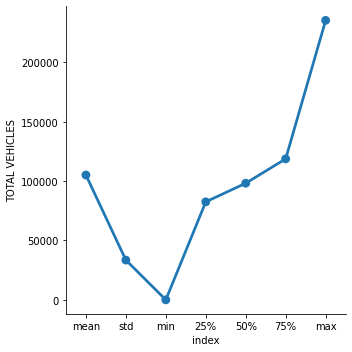

In [10]:
for i in num_col:
  if i in ['index']:
    continue
  sns.factorplot(x='index', y=i, data=describe_df)
  plt.show()

**Plotting Null Values**



In [11]:
null_df = task1_df.apply(lambda x: sum(x.isnull())).to_frame(name='null_count')
print(null_df)

                null_count
Date                     0
TOTAL VEHICLES           0


**Plotting time series for Total Vehicles**

No handles with labels found to put in legend.


(array([722815., 724642., 726468., 728294., 730120., 731947., 733773.,
        735599., 737425., 739252.]),
 <a list of 10 Text major ticklabel objects>)

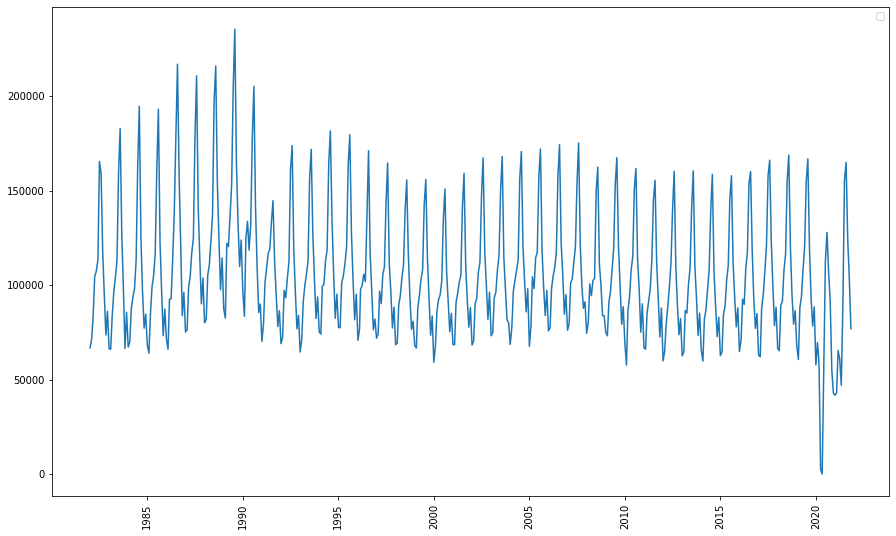

In [12]:
task1_df = task1_df.sort_values('Date', ascending=True)
plt.figure(figsize=(15,9))
plt.plot(task1_df['Date'], task1_df['TOTAL VEHICLES'])
plt.legend()
plt.xticks(rotation='vertical')

In [13]:
task1_df = task1_df.set_index('Date')
task1_df = task1_df['1982-01':'2021-11'].resample('MS').sum()
#index= pd.date_range(start='1982-01', end='2021-11', freq='MS')

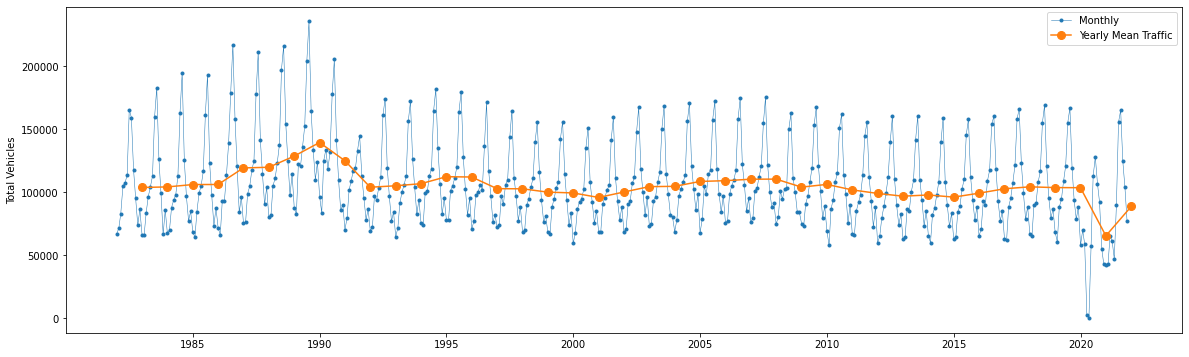

In [14]:
y = task1_df['TOTAL VEHICLES']

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Yearly Mean Traffic')
#ax.bar(task1_df.index.values,
#       task1_df['TOTAL VEHICLES'],
#       color='purple')
ax.set_ylabel('Total Vehicles')
ax.legend()

By looking at the graph above, we can say that there is a seasonal trend.

In [15]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', freq=10)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


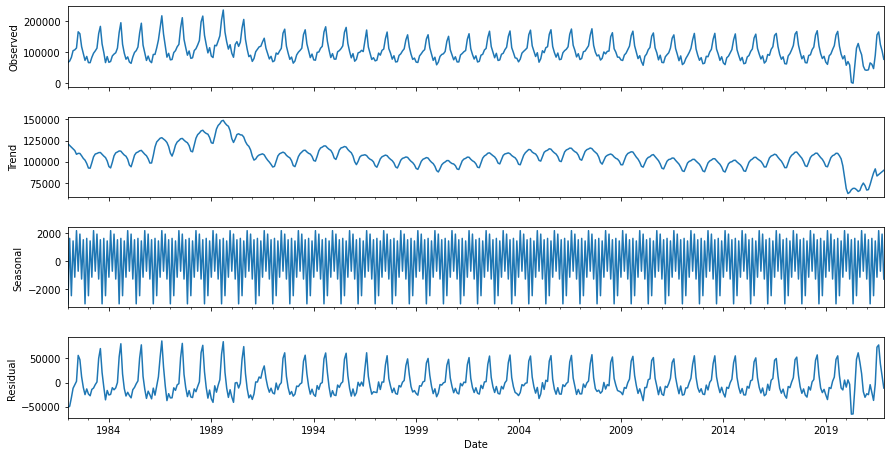

In [16]:
seasonal_decompose(y)

After looking at the four pieces of decomposed graphs, we can tell that our traffic dataset has an overall same trend as well as a yearly seasonality. Depending on the components of your dataset like trend, seasonality, or cycles, the choice of model will be different. 

**Check for Stationarity**

A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time. Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test

In [17]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

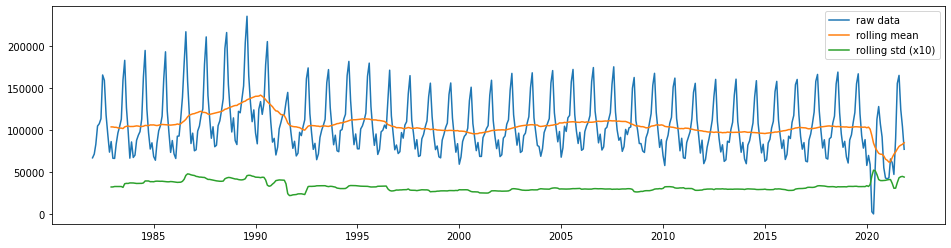

In [18]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.

**Augmented Dickey-Fuller Test**

In [19]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [20]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.220
P-value = 0.019
Critical values :
	1%: -3.4446148284445153 - The data is not stationary with 99% confidence
	5%: -2.8678299626609314 - The data is  stationary with 95% confidence
	10%: -2.5701203107928157 - The data is  stationary with 90% confidence


Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.

**Creating Testing & Training Datasets**

In [21]:
len(y)

479

In [22]:
y_to_train = y[:'2018-12-01'] # dataset to train
y_to_val = y['2019-01-01':] # last X months for test
#y_to_train = task1_df.iloc[0:440, ] # dataset to train
#y_to_val =  task1_df.iloc[441:, ]# last X months for test
predict_date = len(y) - len(y[:'2019-01-01']) # the number of data points for the test set
print(predict_date)

34


In [23]:
print(len(y_to_train))

444


In [24]:
y_to_train.head()

Date
1982-01-01     66805
1982-02-01     71309
1982-03-01     82963
1982-04-01    104694
1982-05-01    107352
Freq: MS, Name: TOTAL VEHICLES, dtype: int64

In [25]:
y_to_train.tail()

Date
2018-08-01    168949
2018-09-01    120551
2018-10-01     95248
2018-11-01     79373
2018-12-01     86493
Freq: MS, Name: TOTAL VEHICLES, dtype: int64

**Choosing appropriate Forecasting Model**

We will take a look at four prediction models: Simple Exponential Smoothing (SES), Holt, Seasonal Holt-Winters, and Seasonal ARIMA (SARIMA). Then we will evaluate these forecasting models to determine which is best for our sample dataset.

**Simple Exponential Smoothing (SES)**
Suitable for time series data without trend or seasonal components

In [26]:
y.head()

Date
1982-01-01     66805
1982-02-01     71309
1982-03-01     82963
1982-04-01    104694
1982-05-01    107352
Freq: MS, Name: TOTAL VEHICLES, dtype: int64

In [27]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    print('fcast1', fcast1)
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='yellow', legend=True)
    fit2.fittedvalues.plot(marker='o', color='yellow')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    

fcast1 2019-01-01   85976.75848220
2019-02-01   85976.75848220
2019-03-01   85976.75848220
2019-04-01   85976.75848220
2019-05-01   85976.75848220
2019-06-01   85976.75848220
2019-07-01   85976.75848220
2019-08-01   85976.75848220
2019-09-01   85976.75848220
2019-10-01   85976.75848220
2019-11-01   85976.75848220
2019-12-01   85976.75848220
2020-01-01   85976.75848220
2020-02-01   85976.75848220
2020-03-01   85976.75848220
2020-04-01   85976.75848220
2020-05-01   85976.75848220
2020-06-01   85976.75848220
2020-07-01   85976.75848220
2020-08-01   85976.75848220
2020-09-01   85976.75848220
2020-10-01   85976.75848220
2020-11-01   85976.75848220
2020-12-01   85976.75848220
2021-01-01   85976.75848220
2021-02-01   85976.75848220
2021-03-01   85976.75848220
2021-04-01   85976.75848220
2021-05-01   85976.75848220
2021-06-01   85976.75848220
2021-07-01   85976.75848220
2021-08-01   85976.75848220
2021-09-01   85976.75848220
2021-10-01   85976.75848220
Freq: MS, Name: $\alpha=0.8$, dtype: floa

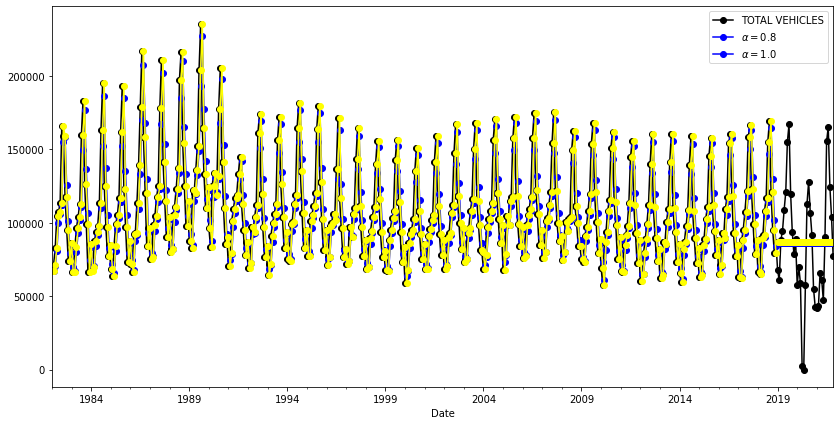

In [28]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

In [32]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    print('fit1', fit1)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    print('fcast1', fcast1)
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    print('fit2', fit2)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

fit1 <statsmodels.tsa.holtwinters.HoltWintersResultsWrapper object at 0x7fa0078d36d0>
fcast1 2019-01-01    81840.29215033
2019-02-01    76458.41145772
2019-03-01    71076.53076511
2019-04-01    65694.65007250
2019-05-01    60312.76937988
2019-06-01    54930.88868727
2019-07-01    49549.00799466
2019-08-01    44167.12730205
2019-09-01    38785.24660944
2019-10-01    33403.36591683
2019-11-01    28021.48522422
2019-12-01    22639.60453161
2020-01-01    17257.72383900
2020-02-01    11875.84314639
2020-03-01     6493.96245378
2020-04-01     1112.08176117
2020-05-01    -4269.79893144
2020-06-01    -9651.67962405
2020-07-01   -15033.56031666
2020-08-01   -20415.44100927
2020-09-01   -25797.32170188
2020-10-01   -31179.20239449
2020-11-01   -36561.08308710
2020-12-01   -41942.96377971
2021-01-01   -47324.84447232
2021-02-01   -52706.72516493
2021-03-01   -58088.60585754
2021-04-01   -63470.48655015
2021-05-01   -68852.36724276
2021-06-01   -74234.24793537
2021-07-01   -79616.12862798
2021-08-

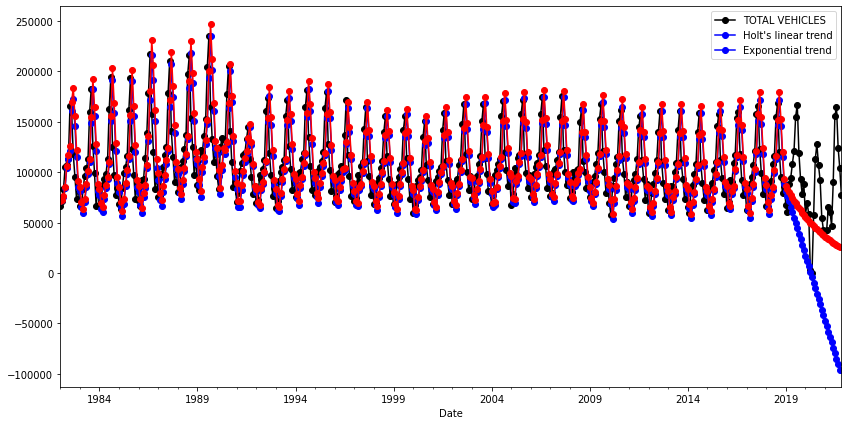

In [33]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)


**Holt-Winters’ Seasonal Method**

The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ.

There are two general types of seasonality: Additive and Multiplicative. 

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(30, 10))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=12 and a Box-Cox transformation 34731.93


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,


The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=12 and a Box-Cox transformation nan


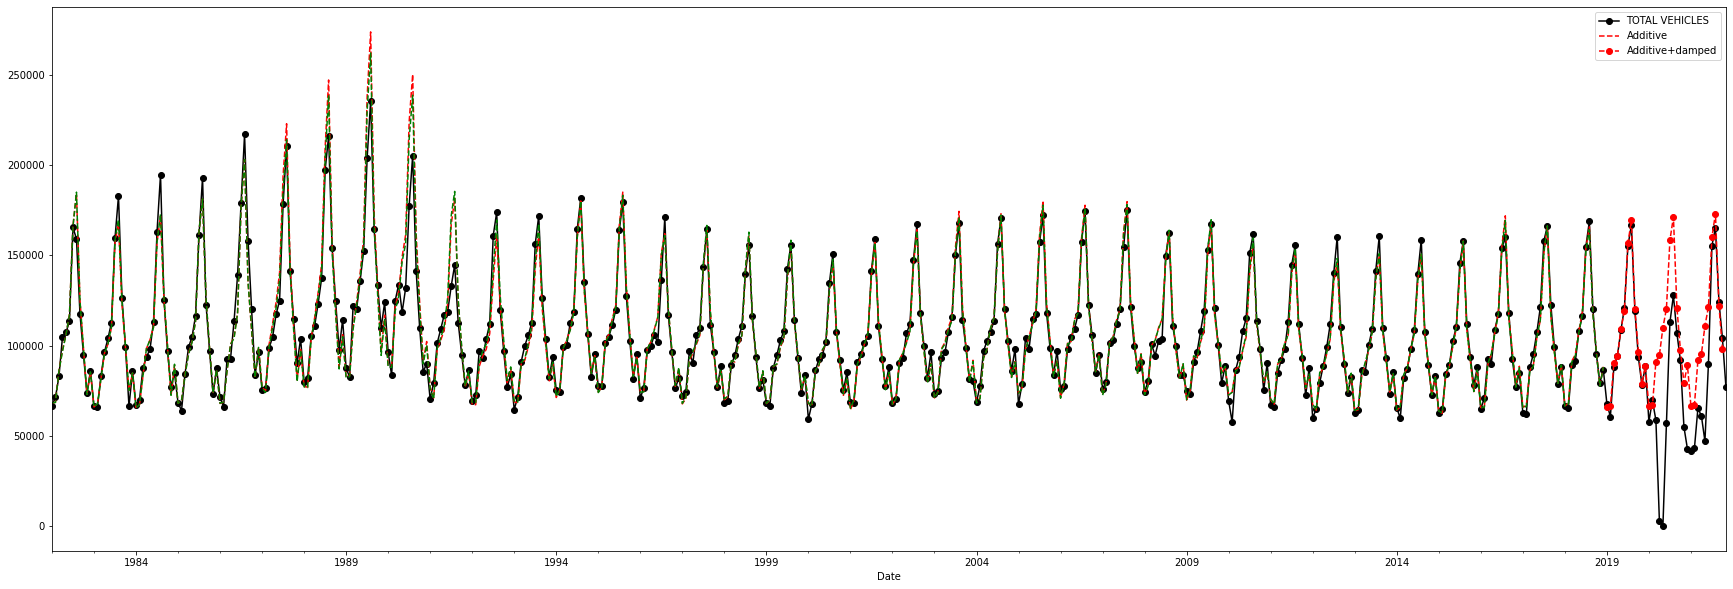

In [43]:
holt_win_sea(y, y_to_train,y_to_val,'additive',12, predict_date)

The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far. However, the RMSE is not better than the results from the simple SES model. And we can also tell that the forecast starts to drop off towards the end.

**SARIMA** - Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in your data.

Trend Elements: \\

p: Trend autoregression order. \\
d: Trend difference order. \\
q: Trend moving average order. \\

Seasonal Elements: \\
P: Seasonal autoregressive order. \\
D: Seasonal difference order. \\
Q: Seasonal moving average order. \\
m: The number of time steps for a single seasonal period.

In [41]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                    print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [44]:
sarima_grid_search(y,12)

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:12459.79425272555
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:11829.151317258656
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:10146.33152973382
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:9859.736275316152
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:9855.59043614898
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:9574.48986133879
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:9573.300210674868
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:9443.646991770218
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:9441.790472400731
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:9437.399896446568
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:9435.855700235114
SARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:9432.810441908321
SARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:9429.351489931889
SARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:9411.022706574455
SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:9408.75245426461
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:9408.75245426461


In [45]:
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7605      0.029     25.908      0.000       0.703       0.818
ma.L1          0.1147      0.040      2.870      0.004       0.036       0.193
ar.S.L12      -0.2212      0.118     -1.876      0.061      -0.452       0.010
ma.S.L12      -0.2715      0.102     -2.658      0.008      -0.472      -0.071
sigma2      7.369e+07   5.77e-10   1.28e+17      0.000    7.37e+07    7.37e+07


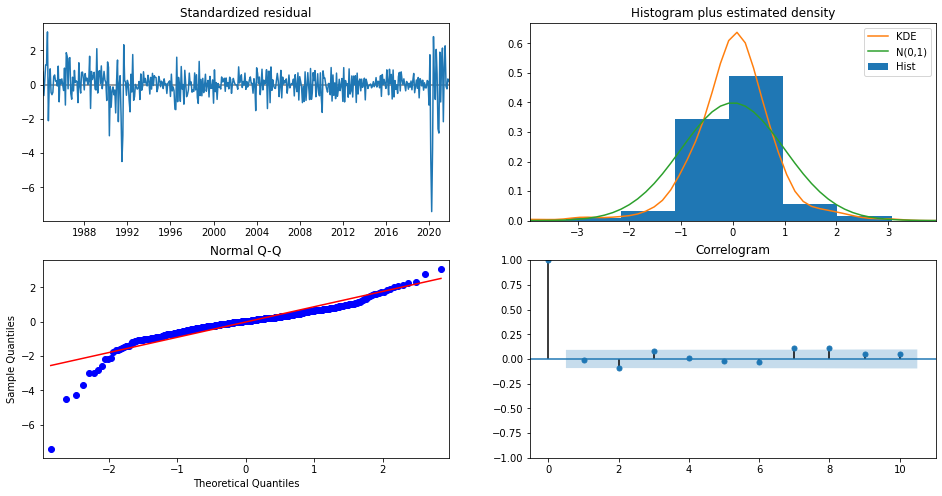

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 8830.1


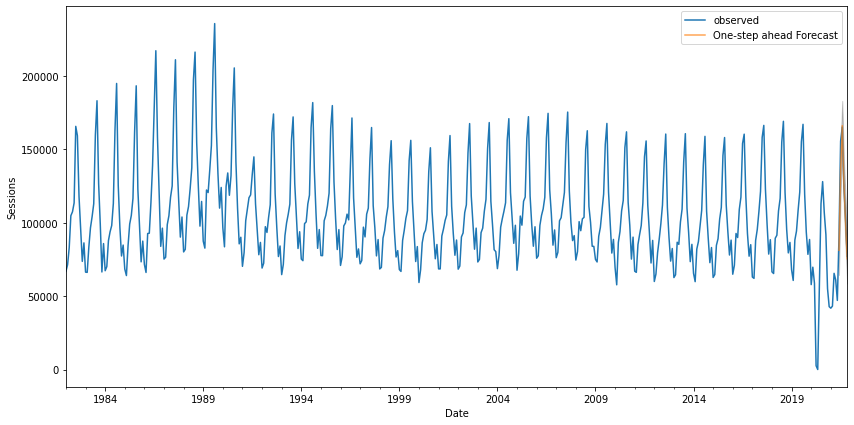

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 17385.58


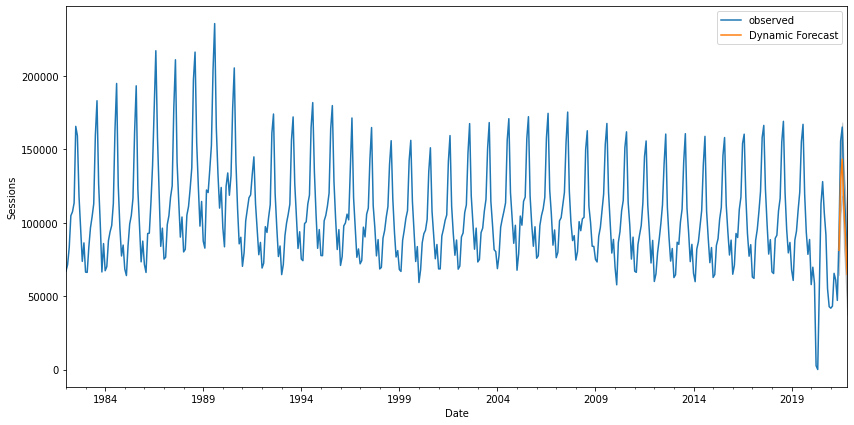

In [47]:
model = sarima_eva(y,(1, 0, 1),(1, 1, 1, 12),12,'2021-06-01',y_to_val)

In [48]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

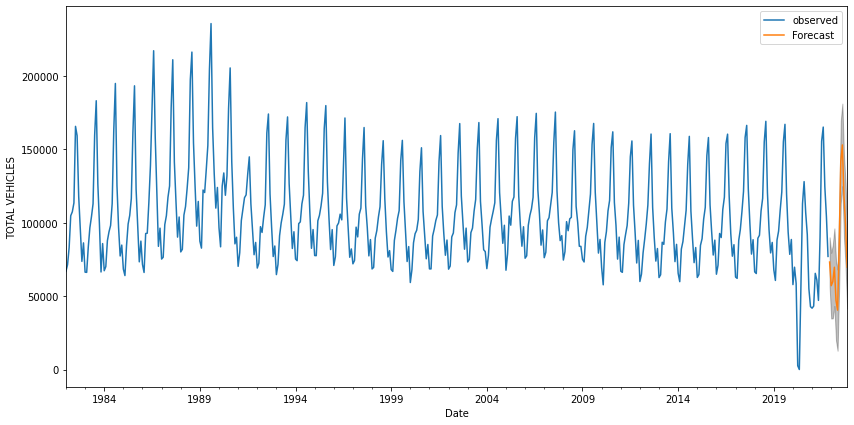

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-12-01,73146.96940671,56322.08019647,89971.85861695
1,2022-01-01,57053.96351734,34695.36130602,79412.56572866
2,2022-02-01,59820.26226368,34813.86505440,84826.65947296
3,2022-03-01,69634.88110397,43217.88577555,96051.87643239
4,2022-04-01,47042.12742696,19842.62601495,74241.62883896


In [49]:
final_table = forecast(model,12,y)
final_table.head()

In [ ]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(20, 10))
model_fit.plot_predict(dynamic=False, ax=ax,
                           plot_insample=True)
plt.show()

In [ ]:
y_to_train = y[:'2018-12-01'] # dataset to train
y_to_val = y['2019-01-01':] # last X months for test
#y_to_train = task1_df.iloc[0:440, ] # dataset to train
#y_to_val =  task1_df.iloc[441:, ]# last X months for test
predict_date = len(y) - len(y[:'2019-01-01']) # the number of data points for the test set
print(predict_date)

In [ ]:
from statsmodels.tsa.stattools import acf
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(y_to_train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(35, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=y_to_val.index)
lower_series = pd.Series(conf[:, 0], index=y_to_val.index)
upper_series = pd.Series(conf[:, 1], index=y_to_val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_to_train, label='training')
plt.plot(y_to_val, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [ ]:
def model_ARIMA_2(y, order):
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima_model import ARIMAResults    
    model = ARIMA(y, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)
def step_ARIMA(resid, p_max, d_max, q_max):
    from statsmodels.tsa.arima_model import ARIMAResults    
    from statsmodels.tsa.arima_model import ARIMA
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model)
BIC, order, model = step_ARIMA(decomp.resid[6:-6], 3, 3, 3)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))